## Imports

In [1]:
import os
import json

import numpy as np
import iris
import iris.plot as iplt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
import cartopy.crs as ccrs

mpl.rcParams.update({'font.size': 12})

## Define some useful functions

In [2]:
def ext(cube,region):
    """Extract region from cube."""
    return cube.intersection(longitude=(region[0], region[2]), latitude=(region[1], region[3]))


def prepare_for_merge(cube, realization):
    """Prepare cube for merging, for ensemble statistics."""
    cube.var_name = 'n_gb_mean'
    realization_coord = iris.coords.AuxCoord(np.int32(realization), "realization", units="1")
    try:
        cube.add_aux_coord(realization_coord)
    except Exception as e:
        pass
    return cube


def area_avg_cube(cube):
    """Calculate an area-weighted average of cube."""
    if type(cube) == iris.cube.Cube:
        if not cube.coord('latitude').has_bounds():
            cube.coord('latitude').guess_bounds()
        if not cube.coord('longitude').has_bounds():
            cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)
        
        new_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    
    else:
        raise TypeError('Function only accepts cubes')
    
    return new_cube


def get_ensemble_statistics(cube_dict):
    cubes_c1 = cube_dict['C1-IMP-Ren']
    cubes_c2 = cube_dict['C2-IMP-Neg']
    cubes_c3 = cube_dict['C3-IMP-GS']
    
    stats = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
    for p in cubes_c1:
        realization = 0
        for c1 in cubes_c1[p]:
            c1 = prepare_for_merge(c1, realization)
            realization += 1
        realization = 0
        for c2 in cubes_c2[p]:
            c2 = prepare_for_merge(c2, realization)
            realization += 1
        realization = 0
        for c3 in cubes_c3[p]:
            c3 = prepare_for_merge(c3, realization)
            realization += 1

        # this just deletes any attributes that don't match between cubes in the cubelist
        # which removes errors whilst merging
        iris.util.equalise_attributes(cubes_c1[p])
        iris.util.equalise_attributes(cubes_c2[p])
        iris.util.equalise_attributes(cubes_c3[p])

        mm_cube_c1 = cubes_c1[p].merge_cube()
        mm_cube_c2 = cubes_c2[p].merge_cube()
        mm_cube_c3 = cubes_c3[p].merge_cube()

        # Means
        c1_mean = mm_cube_c1.collapsed('realization', iris.analysis.MEAN)
        c2_mean = mm_cube_c2.collapsed('realization', iris.analysis.MEAN)
        c3_mean = mm_cube_c3.collapsed('realization', iris.analysis.MEAN)

        # Medians
        c1_median = mm_cube_c1.collapsed('realization', iris.analysis.MEDIAN)
        c2_median = mm_cube_c2.collapsed('realization', iris.analysis.MEDIAN)
        c3_median = mm_cube_c3.collapsed('realization', iris.analysis.MEDIAN)

        # Maxes
        c1_max = mm_cube_c1.collapsed('realization', iris.analysis.MAX)
        c2_max = mm_cube_c2.collapsed('realization', iris.analysis.MAX)
        c3_max = mm_cube_c3.collapsed('realization', iris.analysis.MAX)

        # Mins
        c1_min = mm_cube_c1.collapsed('realization', iris.analysis.MIN)
        c2_min = mm_cube_c2.collapsed('realization', iris.analysis.MIN)
        c3_min = mm_cube_c3.collapsed('realization', iris.analysis.MIN)

        stats['C1-IMP-Ren'][p] = [c1_mean, c1_median, c1_max, c1_min]
        stats['C2-IMP-Neg'][p] = [c2_mean, c2_median, c2_max, c2_min]
        stats['C3-IMP-GS'][p] = [c3_mean, c3_median, c3_max, c3_min]

    return stats

def get_regional_stats(cubes, region):
    area_mean = {'c1':{}, 'c2':{}, 'c3':{}}
    area_med = {'c1':{}, 'c2':{}, 'c3':{}}
    area_max = {'c1':{}, 'c2':{}, 'c3':{}}
    area_min = {'c1':{}, 'c2':{}, 'c3':{}}

    for p in cubes['C1-IMP-Ren']:
        area_mean['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][0], region))
        area_mean['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][0], region))
        area_mean['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][0], region))
        
        area_med['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][1], region))
        area_med['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][1], region))
        area_med['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][1], region))
        
        area_max['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][2], region))
        area_max['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][2], region))
        area_max['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][2], region))
        
        area_min['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][3], region))
        area_min['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][3], region))
        area_min['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][3], region))
        
    return [area_mean, area_med, area_max, area_min]


def get_regional_stats_frac(cubes, region):
    area_mean = {'c1':{}, 'c2':{}, 'c3':{}}
    area_med = {'c1':{}, 'c2':{}, 'c3':{}}
    area_max = {'c1':{}, 'c2':{}, 'c3':{}}
    area_min = {'c1':{}, 'c2':{}, 'c3':{}}

    for p in cubes['C1-IMP-Ren']:
        area_mean['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][0][:, :5]), region))
        area_mean['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][0][:, :5]), region))
        area_mean['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][0][:, :5]), region))
        
        area_med['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][1][:, :5]), region))
        area_med['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][1][:, :5]), region))
        area_med['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][1][:, :5]), region))
        
        area_max['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][2][:, :5]), region))
        area_max['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][2][:, :5]), region))
        area_max['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][2][:, :5]), region))
        
        area_min['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][3][:, :5]), region))
        area_min['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][3][:, :5]), region))
        area_min['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][3][:, :5]), region))
        
    return [area_mean, area_med, area_max, area_min]

In [3]:
# Gets parent directory
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
fair_dict_path = f'{parent_dir}/data/ForestRisks_Zenodo/FaIR_output/fair_2300_dict.json'
jules_data_path = f'{parent_dir}/data/ForestRisks_Zenodo/JULES_output'

with open(fair_dict_path) as f:
    fair_dict = json.load(f)

percentiles = ['0.5']
scenarios = ['C1-IMP-Ren', 'C2-IMP-Neg', 'C3-IMP-GS']
variables = ['t1p5m_gb', 'npp_n_gb', 'frac']
t1p5m_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
npp_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
frac_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}

for root, dirs, files in os.walk(jules_data_path):
    for file in files:
        for scenario in scenarios:
            for p in percentiles:
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[0]}_ens.nc')):
                    t1p5m_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(jules_data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[1]}_ens.nc')):
                    npp_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(jules_data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[2]}_ens.nc')):
                    frac_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(jules_data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
       

In [4]:
time_coord = t1p5m_cubes['C1-IMP-Ren']['0.5'][0].coord('time')
for scen in scenarios:
    for p in percentiles:
        for i, model in enumerate(t1p5m_cubes[scen][p]):
            t1p5m_cubes[scen][p][i].remove_coord('time')
            t1p5m_cubes[scen][p][i].add_dim_coord(time_coord, 0)
            
            npp_cubes[scen][p][i].remove_coord('time') 
            npp_cubes[scen][p][i].add_dim_coord(time_coord, 0)
            
            frac_cubes[scen][p][i].remove_coord('time')
            frac_cubes[scen][p][i].add_dim_coord(time_coord, 0)
            
for scen in scenarios:
    for p in percentiles:
        for i, model in enumerate(t1p5m_cubes[scen][p]):
            if model.attributes['source'].split('/')[6].split('_')[0] in ['NorESM2-LM', 'KACE-1-0-G', 'E3SM-1-0']:
                t1p5m_cubes[scen][p].pop(i)
                frac_cubes[scen][p].pop(i)
                npp_cubes[scen][p].pop(i)    

Define regions

In [11]:
region = {
    "amazon": [-90,-40,-15,10],
    "amazon_map": [-105,-35,-15,10],
    "siberia": [45, 45, 135, 80],
    "siberia_map": [45, 40, 135, 85],
    "global": [-180, -90, 180, 90]
}

Merge cubelists for ensemble statistics

In [12]:
%%capture
npp_stats = get_ensemble_statistics(npp_cubes)
t1p5m_stats = get_ensemble_statistics(t1p5m_cubes)
frac_stats = get_ensemble_statistics(frac_cubes)

Calculate area averages for timeseries plots

In [13]:
%%capture
npp_area_list_amazon = get_regional_stats(npp_stats, region=region['amazon'])
t1p5m_area_list_amazon = get_regional_stats(t1p5m_stats, region=region['amazon'])
frac_area_list_amazon = get_regional_stats_frac(frac_stats, region=region['amazon'])

npp_area_list_siberia = get_regional_stats(npp_stats, region=region['siberia'])
t1p5m_area_list_siberia = get_regional_stats(t1p5m_stats, region=region['siberia'])
frac_area_list_siberia = get_regional_stats_frac(frac_stats, region=region['siberia'])

Calculate Amazon and Siberia region areas

In [14]:
# calculate amazon grid area
area_cube = iris.load_cube(f'{parent_dir}/data/ForestRisks_Zenodo/JULES_output/gmtchange_es_area.nc')
amazon_area = np.sum(ext(area_cube, region['amazon']).data) * 1e6 # km2 = m2
siberia_area = np.sum(ext(area_cube, region['siberia']).data) * 1e6 # km2 = m2
amazon_conv = amazon_area / 1e12 # conv: kg m-2 y-1 -> PgC
siberia_conv = siberia_area / 1e12 # conv: kg m-2 y-1 -> PgC

In [15]:
scens = ['c1', 'c2', 'c3']
time = np.arange(2000, 2300, 10)
decs = len(time)

##### Calculate regional temp anomalies

In [16]:
%%capture
# Calculate regional temperature anomaly 1850-1900
temp_median_amazon = t1p5m_area_list_amazon[0]
regional_temp_baseline_amazon = {'c1': {}, 'c2': {}, 'c3': {}}
scens = ['c1', 'c2', 'c3']
for scen in scens:
    for p in percentiles:
        regional_temp_baseline_amazon[scen][p] = temp_median_amazon[scen][p][:5].collapsed('time', iris.analysis.MEAN)
        
temp_median_siberia = t1p5m_area_list_siberia[1]
regional_temp_baseline_siberia = {'c1': {}, 'c2': {}, 'c3': {}}
scens = ['c1', 'c2', 'c3']
for scen in scens:
    for p in percentiles:
        regional_temp_baseline_siberia[scen][p] = temp_median_siberia[scen][p][:5].collapsed('time', iris.analysis.MEAN)

Calculate anomalies

In [17]:
temp_median_amazon_anomaly_c1 = temp_median_amazon['c1']['0.5'][-decs:].data - regional_temp_baseline_amazon['c1']['0.5'].data
temp_median_amazon_anomaly_c2 = temp_median_amazon['c2']['0.5'][-decs:].data - regional_temp_baseline_amazon['c2']['0.5'].data
temp_median_amazon_anomaly_c3 = temp_median_amazon['c3']['0.5'][-decs:].data - regional_temp_baseline_amazon['c3']['0.5'].data

temp_median_siberia_anomaly_c1 = temp_median_siberia['c1']['0.5'][-decs:].data - regional_temp_baseline_siberia['c1']['0.5'].data
temp_median_siberia_anomaly_c2 = temp_median_siberia['c2']['0.5'][-decs:].data - regional_temp_baseline_siberia['c2']['0.5'].data
temp_median_siberia_anomaly_c3 = temp_median_siberia['c3']['0.5'][-decs:].data - regional_temp_baseline_siberia['c3']['0.5'].data

In [18]:
# Baselines for frac and NPP calculated in figure 3 notebook
frac_baseline_amazon = 0.4049183403189171
frac_baseline_siberia = 0.2549000854052015
npp_baseline_amazon = 9.834009253483387
npp_baseline_siberia = 2.5685072983979635

In [19]:
scens = ['C1-IMP-Ren', 'C2-IMP-Neg', 'C3-IMP-GS']
        
npp_area_mean = {
    'amazon': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'amazon_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
    }
}
for scen in scens:
    for p in percentiles:
        npp_area_mean['amazon'][scen][p] = ext(npp_stats[scen][p][0]*amazon_conv, region['amazon'])
        npp_area_mean['siberia'][scen][p] = ext(npp_stats[scen][p][0]*siberia_conv, region['siberia'])
        npp_area_mean['amazon_map'][scen][p] = ext(npp_stats[scen][p][0]*amazon_conv, region['amazon_map'])
        npp_area_mean['siberia_map'][scen][p] = ext(npp_stats[scen][p][0]*siberia_conv, region['siberia_map'])
        
frac_area_mean = {
    'amazon': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'amazon_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
    }
}
for scen in scens:
    for p in percentiles:
        frac_area_mean['amazon'][scen][p] = ext(frac_stats[scen][p][0], region['amazon'])  
        frac_area_mean['siberia'][scen][p] = ext(frac_stats[scen][p][0], region['siberia'])     
        frac_area_mean['amazon_map'][scen][p] = ext(frac_stats[scen][p][0], region['amazon_map'])  
        frac_area_mean['siberia_map'][scen][p] = ext(frac_stats[scen][p][0], region['siberia_map'])    

temp_area_mean = {
    'amazon': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'amazon_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
    }
}
for scen in scens:
    for p in percentiles:
        temp_area_mean['amazon'][scen][p] = ext(t1p5m_stats[scen][p][0]-273.15, region['amazon'])
        temp_area_mean['siberia'][scen][p] = ext(t1p5m_stats[scen][p][0]-273.15, region['siberia'])
        temp_area_mean['amazon_map'][scen][p] = ext(t1p5m_stats[scen][p][0]-273.15, region['amazon_map'])
        temp_area_mean['siberia_map'][scen][p] = ext(t1p5m_stats[scen][p][0]-273.15, region['siberia_map'])

#### Plot figure 2

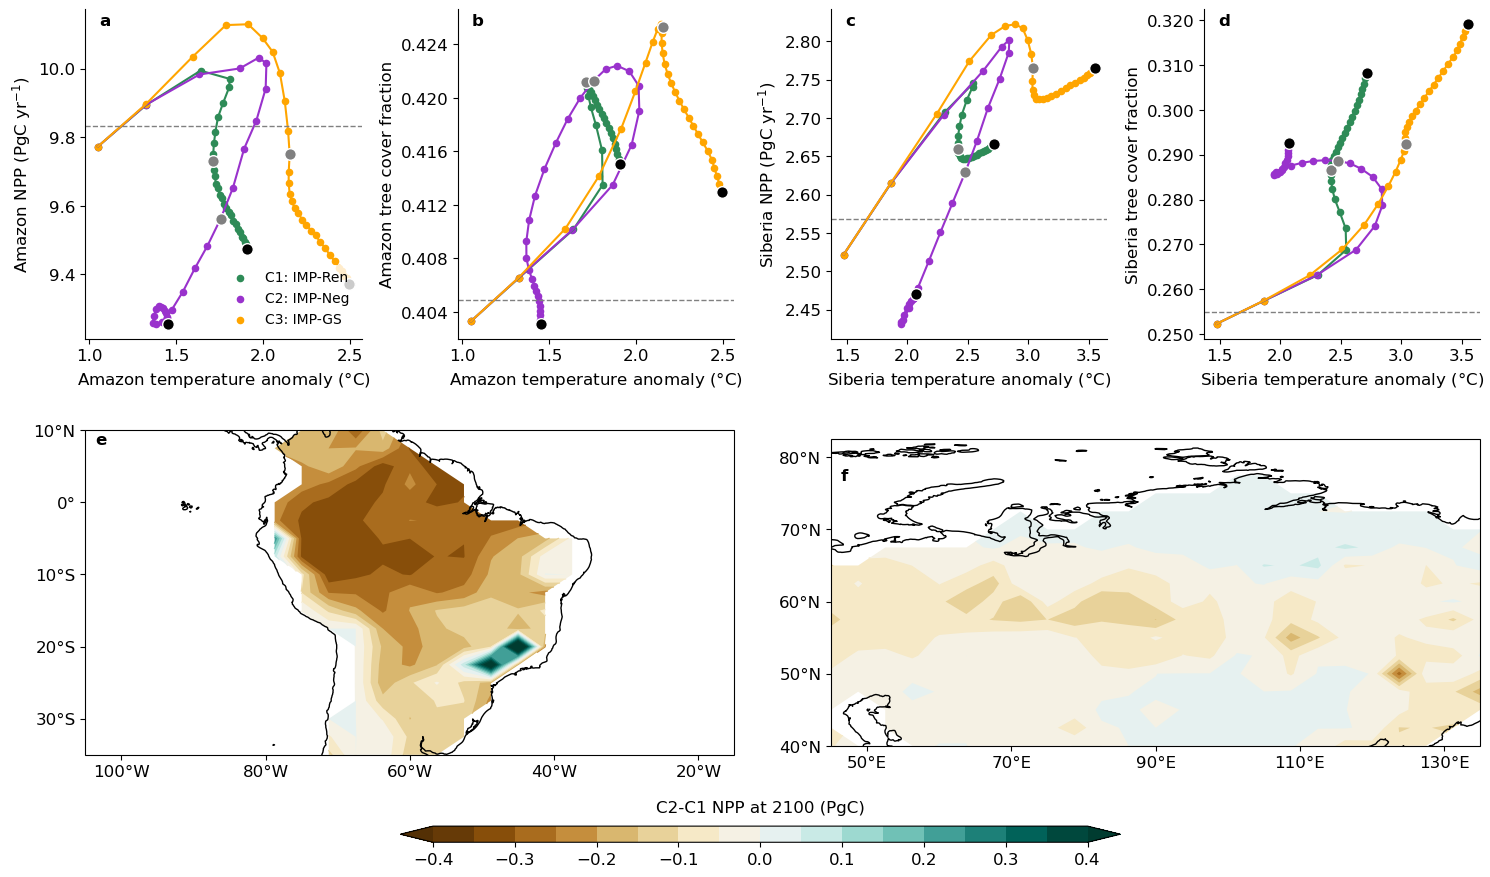

In [20]:
overshoot_peak_ms = 70
linealpha=1
lineps=20
endofline_size=70

frac_mean_amazon = frac_area_list_amazon[0]
npp_mean_amazon = npp_area_list_amazon[0]
frac_mean_siberia = frac_area_list_siberia[0]
npp_mean_siberia = npp_area_list_siberia[0]

amazon_conv = amazon_area / 1e12
siberia_conv = siberia_area / 1e12

levels = np.arange(-0.4,0.45,0.05)

X = [ (1,1), (2,2), (3,3), (4,4),
      (5,6),        (7,8)]


fig = plt.figure(figsize=(18, 8.5))

ax = fig.add_subplot(2, 4, X[1])
# ax.set_title('Amazon Tree fraction')
ax.scatter(temp_median_amazon_anomaly_c1, np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', label="C1: IMP-Ren", s=lineps)
ax.plot(temp_median_amazon_anomaly_c1, np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', alpha=linealpha)
ax.scatter(temp_median_amazon_anomaly_c2, np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', label="C2: IMP-Neg", s=lineps)
ax.plot(temp_median_amazon_anomaly_c2, np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', alpha=linealpha)
ax.scatter(temp_median_amazon_anomaly_c3, np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', label="C3: IMP-GS", s=lineps)
ax.plot(temp_median_amazon_anomaly_c3, np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', alpha=linealpha)

# Plot overshoot peaks + ends
ax.scatter(temp_median_amazon_anomaly_c1[-20], np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', edgecolor='white', marker='o', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_amazon_anomaly_c2[-20], np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', edgecolor='white', marker='o', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_amazon_anomaly_c3[-20], np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', edgecolor='white', marker='o', zorder=2, s=overshoot_peak_ms)

ax.scatter(temp_median_amazon_anomaly_c1[-1], np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_amazon_anomaly_c2[-1], np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_amazon_anomaly_c3[-1], np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Amazon temperature anomaly ($\degree$C)')
ax.set_ylabel('Amazon tree cover fraction')

ax.axhline(frac_baseline_amazon, linestyle='--', lw=1, color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_locator(MultipleLocator(0.004))
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'b', transform=ax.transAxes, color='black', weight='bold')

ax = fig.add_subplot(2, 4, X[0])
# ax.set_title('Amazon NPP')
ax.scatter(temp_median_amazon_anomaly_c1, npp_mean_amazon['c1']['0.5'][-decs:].data*amazon_conv, color='seagreen', s=lineps, label="C1: IMP-Ren")
ax.plot(temp_median_amazon_anomaly_c1, npp_mean_amazon['c1']['0.5'][-decs:].data*amazon_conv, color='seagreen', alpha=linealpha)
ax.scatter(temp_median_amazon_anomaly_c2, npp_mean_amazon['c2']['0.5'][-decs:].data*amazon_conv, color='darkorchid', s=lineps, label="C2: IMP-Neg")
ax.plot(temp_median_amazon_anomaly_c2, npp_mean_amazon['c2']['0.5'][-decs:].data*amazon_conv, color='darkorchid', alpha=linealpha)
ax.scatter(temp_median_amazon_anomaly_c3, npp_mean_amazon['c3']['0.5'][-decs:].data*amazon_conv, color='orange', s=lineps, label="C3: IMP-GS")
ax.plot(temp_median_amazon_anomaly_c3, npp_mean_amazon['c3']['0.5'][-decs:].data*amazon_conv, color='orange', alpha=linealpha)

# Plot overshoot peak
ax.scatter(temp_median_amazon_anomaly_c1[-20], npp_mean_amazon['c1']['0.5'][-decs:].data[-20]*amazon_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_amazon_anomaly_c2[-20], npp_mean_amazon['c2']['0.5'][-decs:].data[-20]*amazon_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_amazon_anomaly_c3[-20], npp_mean_amazon['c3']['0.5'][-decs:].data[-20]*amazon_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)

ax.scatter(temp_median_amazon_anomaly_c1[-1], npp_mean_amazon['c1']['0.5'][-decs:].data[-1]*amazon_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_amazon_anomaly_c2[-1], npp_mean_amazon['c2']['0.5'][-decs:].data[-1]*amazon_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_amazon_anomaly_c3[-1], npp_mean_amazon['c3']['0.5'][-decs:].data[-1]*amazon_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Amazon temperature anomaly ($\degree$C)')
ax.set_ylabel('Amazon NPP (PgC yr$^{-1}$)')

ax.text(0.05, 0.95, 'a', transform=ax.transAxes, color='black', weight='bold')

ax.spines[['right', 'top']].set_visible(False)
ax.axhline(npp_baseline_amazon, linestyle='--', lw=1, color='grey')

plt.legend(loc='lower right', edgecolor='none', prop={'size': 10})

ax = fig.add_subplot(2, 4, X[3])
# ax.set_title('Siberia Tree fraction')
ax.scatter(temp_median_siberia_anomaly_c1, np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', s=lineps)
ax.plot(temp_median_siberia_anomaly_c1, np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', alpha=linealpha)
ax.scatter(temp_median_siberia_anomaly_c2, np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', s=lineps)
ax.plot(temp_median_siberia_anomaly_c2, np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', alpha=linealpha)
ax.scatter(temp_median_siberia_anomaly_c3, np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', s=lineps)
ax.plot(temp_median_siberia_anomaly_c3, np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', alpha=linealpha)

# Plot overshoot peaks + ends
ax.scatter(temp_median_siberia_anomaly_c1[-20], np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_siberia_anomaly_c2[-20], np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_siberia_anomaly_c3[-20], np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)

ax.scatter(temp_median_siberia_anomaly_c1[-1], np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_siberia_anomaly_c2[-1], np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_siberia_anomaly_c3[-1], np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Siberia temperature anomaly ($\degree$C)')
ax.set_ylabel('Siberia tree cover fraction')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# ax.yaxis.set_major_locator(MultipleLocator(0.004))
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'd', transform=ax.transAxes, color='black', weight='bold')

ax.axhline(frac_baseline_siberia, linestyle='--', lw=1, color='grey')

ax = fig.add_subplot(2, 4, X[2])
# ax.set_title('Siberia NPP')
ax.scatter(temp_median_siberia_anomaly_c1, npp_mean_siberia['c1']['0.5'][-decs:].data*siberia_conv, color='seagreen', s=lineps)
ax.plot(temp_median_siberia_anomaly_c1, npp_mean_siberia['c1']['0.5'][-decs:].data*siberia_conv, color='seagreen', alpha=linealpha)
ax.scatter(temp_median_siberia_anomaly_c2, npp_mean_siberia['c2']['0.5'][-decs:].data*siberia_conv, color='darkorchid', s=lineps)
ax.plot(temp_median_siberia_anomaly_c2, npp_mean_siberia['c2']['0.5'][-decs:].data*siberia_conv, color='darkorchid', alpha=linealpha)
ax.scatter(temp_median_siberia_anomaly_c3, npp_mean_siberia['c3']['0.5'][-decs:].data*siberia_conv, color='orange', s=lineps)
ax.plot(temp_median_siberia_anomaly_c3, npp_mean_siberia['c3']['0.5'][-decs:].data*siberia_conv, color='orange', alpha=linealpha)

# Plot 2100 points
ax.scatter(temp_median_siberia_anomaly_c1[-20], npp_mean_siberia['c1']['0.5'][-decs:].data[-20]*siberia_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_siberia_anomaly_c2[-20], npp_mean_siberia['c2']['0.5'][-decs:].data[-20]*siberia_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_siberia_anomaly_c3[-20], npp_mean_siberia['c3']['0.5'][-decs:].data[-20]*siberia_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)

ax.scatter(temp_median_siberia_anomaly_c1[-1], npp_mean_siberia['c1']['0.5'][-decs:].data[-1]*siberia_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_siberia_anomaly_c2[-1], npp_mean_siberia['c2']['0.5'][-decs:].data[-1]*siberia_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_siberia_anomaly_c3[-1], npp_mean_siberia['c3']['0.5'][-decs:].data[-1]*siberia_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Siberia temperature anomaly ($\degree$C)')
ax.set_ylabel('Siberia NPP (PgC yr$^{-1}$)')

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'c', transform=ax.transAxes, color='black', weight='bold')

ax.axhline(npp_baseline_siberia, linestyle='--', lw=1, color='grey')
     
# Now plot the maps
    
ax = fig.add_subplot(2, 4, X[4], projection=ccrs.PlateCarree())
# ax.add_feature(cart.feature.OCEAN, zorder=9, edgecolor='k', facecolor="none")
ax.coastlines()

cont = iplt.contourf(
    npp_area_mean['amazon_map']['C2-IMP-Neg']['0.5'][-20] - npp_area_mean['amazon_map']['C1-IMP-Ren']['0.5'][-20], 
    cmap='BrBG', 
    levels=levels, 
    extend='both'
)

ax.set_xticks([-100, -80, -60, -40, -20], crs=ccrs.PlateCarree())
ax.set_xticklabels(['100°W', '80°W', '60°W', '40°W', '20°W'])
ax.set_yticks([-30, -20, -10, 0, 10], crs=ccrs.PlateCarree())
ax.set_yticklabels(['30°S', '20°S', '10°S', '0°', '10°N'])
ax.annotate("e", xy=(0.015, 0.97), xycoords='axes fraction', weight='bold', ha='left', va='center',color="black",zorder=10)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(2, 4, X[5], projection=ccrs.PlateCarree())
# ax.add_feature(cart.feature.OCEAN, zorder=9, edgecolor='k', facecolor="none")
ax.coastlines()

cont = iplt.contourf(
    npp_area_mean['siberia_map']['C2-IMP-Neg']['0.5'][-20] - npp_area_mean['siberia_map']['C1-IMP-Ren']['0.5'][-20], 
    cmap='BrBG', 
    levels=levels, 
    extend='both'
)

ax.set_xticks([50, 70, 90, 110, 130], crs=ccrs.PlateCarree())
ax.set_xticklabels(['50°E', '70°E', '90°E', '110°E', '130°E'])
ax.set_yticks([40, 50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticklabels(['40°N', '50°N', '60°N', '70°N', '80°N'])
ax.annotate("f", xy=(0.015, 0.88), xycoords='axes fraction', weight='bold', ha='left', va='center',color="black",zorder=10) 
ax.spines[['right', 'top']].set_visible(False)

cbar_ax = fig.add_axes([0.3, -0.1, 0.4, 0.019])
fig.colorbar(cont, cax=cbar_ax, orientation='horizontal')
fig.text(0.5,-0.065,"C2-C1 NPP at 2100 (PgC)",ha="center")
fig.subplots_adjust(wspace=0.35, hspace=0.27,bottom=0.0)
    
plt.show()
plt.close()